In [2]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import gluonts
gluonts.__version__

'0.4.2'

In [5]:
import mxnet
mxnet.__version__

'1.4.1'

In [6]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [7]:
dataname = "m4_hourly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.


In [8]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [9]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 414
length test dataset 414


In [10]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,
        402., 427., 456., 500., 558., 608., 661.

## Plot Series

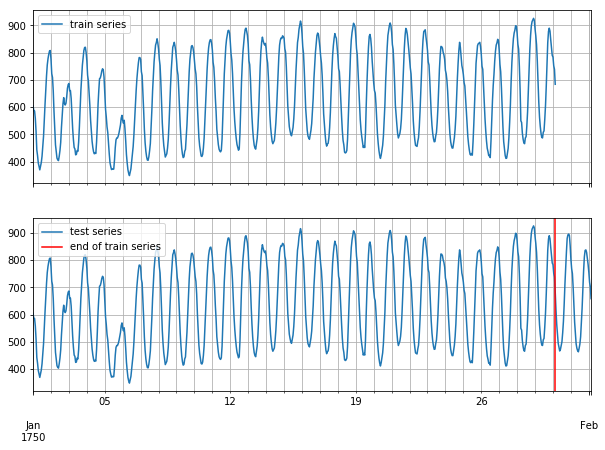

In [11]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [12]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [13]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_demographic", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 123423


Seed: 42


100%|██████████| 200/200 [00:03<00:00, 60.50it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 3.308 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.646961
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.87it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[1] Elapsed time 3.581 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.250682
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.02it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 3.704 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.064428
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.97it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 3.451 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.992352
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 62.96it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[4] Elapsed time 3.178 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 57.86it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[37] Elapsed time 3.458 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.448970
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 58.59it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[38] Elapsed time 3.415 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.434884
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.31it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[39] Elapsed time 3.374 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.467053
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.35it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[40] Elapsed time 3.682 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.428063
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.92it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[41] Elapsed time 3.578 second

100%|██████████| 200/200 [00:04<00:00, 48.94it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[74] Elapsed time 4.090 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.247628
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.60it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[75] Elapsed time 4.117 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.350343
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.19it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[76] Elapsed time 4.068 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.311538
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.00it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[77] Elapsed time 4.084 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.339504
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.83it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[78] Elapsed time 4.186 se

100%|██████████| 200/200 [00:04<00:00, 47.52it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[110] Elapsed time 4.211 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.336797
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.75it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[111] Elapsed time 4.194 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.228249
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.91it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[112] Elapsed time 4.176 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.335738
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.56it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[113] Elapsed time 4.120 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.291373
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.39it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[114] 

100%|██████████| 200/200 [00:04<00:00, 49.33it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[146] Elapsed time 4.056 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.224647
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.65it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[147] Elapsed time 4.113 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.357029
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.13it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[148] Elapsed time 4.072 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.207718
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.32it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[149] Elapsed time 4.141 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.340886
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.18it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.04it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[183] Elapsed time 4.080 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.292869
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.71it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[184] Elapsed time 4.194 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.250149
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.67it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[185] Elapsed time 4.200 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.327589
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.75it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[186] Elapsed time 4.191 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.209504
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.61it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.310280
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.08it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[220] Elapsed time 4.164 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.242042
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.24it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[221] Elapsed time 4.236 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.272153
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.33it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[222] Elapsed time 4.140 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.233731
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.07it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[223] Elapsed time 4.162 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.259698
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 48.82it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[256] Elapsed time 4.099 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.168333
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.59it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[257] Elapsed time 4.118 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.304483
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.91it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[258] Elapsed time 4.177 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.183513
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.29it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[259] Elapsed time 4.147 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.289144
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.09it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[260] Elapsed time 

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.14it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[293] Elapsed time 4.072 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.317832
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.27it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[294] Elapsed time 4.147 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.179304
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.61it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[295] Elapsed time 4.034 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.339982
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.23it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[296] Elapsed time 4.148 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.192511
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.40it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.215958
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.03it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[330] Elapsed time 4.166 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.256760
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.90it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[331] Elapsed time 4.092 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.235629
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.10it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[332] Elapsed time 4.160 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.208049
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.50it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[333] Elapsed time 4.044 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.309687
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 48.57it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[366] Elapsed time 4.119 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.174730
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.45it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[367] Elapsed time 4.046 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.271815
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.96it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[368] Elapsed time 4.005 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.194355
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.84it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[369] Elapsed time 4.100 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.227905
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.53it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.265327  0.102684  12.612242            0.110268            0.056986   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:04<00:00, 47.38it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 4.223 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.594560
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.45it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 4.217 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.206629
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.47it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[2] Elapsed time 4.129 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.008623
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.02it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[3] Elapsed time 4.167 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.918444
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.28it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[4] Elapsed time 4.144 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 47.49it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[37] Elapsed time 4.214 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.531873
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.88it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 4.179 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.378630
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.18it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[39] Elapsed time 4.153 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.476898
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.22it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 4.238 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.448721
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.72it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[41] Elapsed time 4.193 second

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.36it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[74] Elapsed time 4.224 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.305867
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.71it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[75] Elapsed time 4.285 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.301708
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.09it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[76] Elapsed time 4.161 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.355030
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.55it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[77] Elapsed time 4.298 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.284998
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.63it/s, avg_epoch_loss

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.250888
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.89it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[111] Elapsed time 4.092 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.263263
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.72it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[112] Elapsed time 4.193 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.299378
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.62it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[113] Elapsed time 4.202 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.220929
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.34it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[114] Elapsed time 4.227 seconds
INFO:root:Epoch[114] Evaluation metric 'epoc

100%|██████████| 200/200 [00:04<00:00, 48.24it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[146] Elapsed time 4.148 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.322244
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.58it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[147] Elapsed time 4.298 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.189287
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.82it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[148] Elapsed time 4.184 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.304391
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.77it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[149] Elapsed time 4.279 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.220092
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.15it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.81it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[183] Elapsed time 4.185 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.260058
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.64it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[184] Elapsed time 4.201 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.204932
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.71it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[185] Elapsed time 4.107 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.289830
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.82it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[186] Elapsed time 4.187 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.188483
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.75it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.274002
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.25it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[220] Elapsed time 4.149 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.209534
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.92it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[221] Elapsed time 4.090 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.303250
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.29it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[222] Elapsed time 4.144 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.175491
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.24it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[223] Elapsed time 4.064 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.321336
INFO:root:Epoch[224] Learning rate is 5e-05


100%|██████████| 200/200 [00:04<00:00, 47.49it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[256] Elapsed time 4.216 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.239964
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.87it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[257] Elapsed time 4.269 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.257953
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.39it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[258] Elapsed time 4.223 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.167020
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.62it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[259] Elapsed time 4.115 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.266446
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.14it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.66it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[293] Elapsed time 4.112 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.264667
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.03it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[294] Elapsed time 4.166 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.267224
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.35it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[295] Elapsed time 4.226 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.215126
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.77it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[296] Elapsed time 4.102 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.265376
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.81it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.199651
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.40it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[330] Elapsed time 4.224 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.235507
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.61it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[331] Elapsed time 4.203 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.213384
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.89it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[332] Elapsed time 4.178 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.225549
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.46it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[333] Elapsed time 4.128 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.227171
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 47.96it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[366] Elapsed time 4.172 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.209708
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.91it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[367] Elapsed time 4.176 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.159806
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.40it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[368] Elapsed time 4.134 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.290874
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.85it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[369] Elapsed time 4.181 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.165376
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.58it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.262109  0.100702  12.441821            0.109126            0.056987   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:04<00:00, 46.88it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[0] Elapsed time 4.268 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.584085
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.08it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 4.162 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.211632
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.94it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[2] Elapsed time 4.173 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.016018
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.98it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[3] Elapsed time 4.170 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.007143
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.24it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[4] Elapsed time 4.148 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 48.26it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[37] Elapsed time 4.146 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.483942
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.55it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 4.208 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.408115
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.58it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[39] Elapsed time 4.205 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.507804
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.85it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 4.181 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.445710
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.71it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[41] Elapsed time 4.194 second

100%|██████████| 200/200 [00:04<00:00, 47.95it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[74] Elapsed time 4.172 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.285949
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.44it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[75] Elapsed time 4.217 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.418861
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.11it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[76] Elapsed time 4.159 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.319794
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.45it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 4.216 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.427947
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.95it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[78] Elapsed time 4.173 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.40it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[111] Elapsed time 4.221 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.324726
INFO:root:Loading parameters from best epoch (101)
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.68it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[112] Elapsed time 4.197 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.213075
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.90it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[113] Elapsed time 4.177 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.287241
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.07it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[114] Elapsed time 4.162 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.261973
INFO:root:Epoch[115] Learning rate is 0.00025


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_finance", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_industry", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_macro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_micro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_other", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results